In [10]:
from torch import no_grad, manual_seed
import numpy as np
from PIL import Image
from tifffile import imread, imwrite, COMPRESSION
from random import seed
import matplotlib.pyplot as plt
from time import time

from vulture import CompleteUpsampler
from vulture.utils import to_numpy

from xgboost import XGBRegressor

from skimage.restoration import  denoise_tv_chambolle, denoise_wavelet

SEED = 10672
np.random.seed(SEED)
manual_seed(SEED)
seed(SEED)

In [11]:
path = "example_data/ni_on_substrate.tif"

if 'tif' in path.lower():
    img = imread(path)
else:
    img = np.array(Image.open(path).convert('L'))


UP_PATH, DENOISE_PATH, AUTOENC_PATH = "../trained_models/lu_reg_ac48.pth", "../trained_models/dvt.pth", "../trained_models/dac_dv2_denoised_e500.pth"
upsampler = CompleteUpsampler("LOFTUP_COMPRESSED", UP_PATH, DENOISE_PATH, AUTOENC_PATH, device="cuda:0", to_half=True, to_eval=True)

t0 = time()
with no_grad():
    lr_feats_for_vis = upsampler.get_lr_feats(img)
    hr_feats = upsampler.forward(img)

In [12]:
hr_feats_np = to_numpy(hr_feats).astype(np.float32).transpose((1, 2, 0))
h, w, c = hr_feats_np.shape
hr_feats_flat = hr_feats_np.reshape((h * w, c))
img_flat = img.reshape((h * w))

In [13]:
n_samples = 200_000

inds = np.arange(0, len(hr_feats_flat))
np.random.shuffle(inds)
subsample_inds = inds[:n_samples]

train = hr_feats_flat[subsample_inds]
targ = img_flat[subsample_inds]

In [14]:
denoiser = XGBRegressor(n_jobs=20)
denoiser.fit(train, targ)
pred = denoiser.predict(hr_feats_flat)
t1 = time()

ours_time = t1 - t0

In [15]:
img_arr_rgb = np.array(Image.fromarray(img).convert('RGB'))

In [16]:
t0 = time()
tv_chambolle = denoise_tv_chambolle(img_arr_rgb, weight=0.2)
t1 = time()
tv_chambolle_time = t1 - t0

In [17]:
t0 = time()
wavelet = denoise_wavelet(img_arr_rgb, channel_axis=-1, convert2ycbcr=True, rescale_sigma=True)
t1 = time()
wavelet_time = t1 - t0

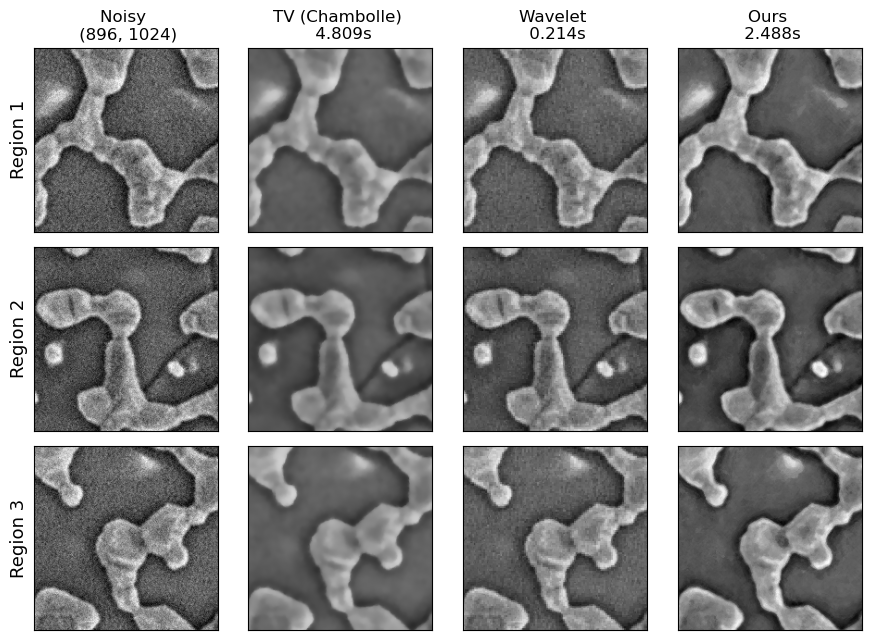

In [18]:
titles = (f'Noisy \n {img.shape}', f'TV (Chambolle) \n {tv_chambolle_time:.3f}s', f'Wavelet \n {wavelet_time:.3f}s', f'Ours \n {ours_time:.3f}s')
imgs = (img,  tv_chambolle, wavelet, pred.reshape(h,w))

subregions = ((0, 0, 200, 200), (400, 400, 200, 200), (300, 0, 200, 200))
fig, axs = plt.subplots(ncols=len(imgs), nrows=len(subregions), figsize=(9, 6.5))

for j, region in enumerate(subregions):
    sx, sy, sw, sh = subregions[j]
    row = axs[j]
    for i, arr in enumerate(imgs):
        ax = row[i]
        ax.imshow(arr[sy:sy+sh, sx:sx+sw], cmap='binary_r')
        
        ax.set_xticks([])
        ax.set_yticks([])

        if j == 0:
            ax.set_title(titles[i])
        if i == 0:
            ax.set_ylabel(f'Region {j + 1}', fontsize=13)
plt.tight_layout()